# 数据预处理

In [1]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Dense, ZeroPadding2D, Dropout, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

file = h5py.File('data/DB1_S1_image.h5','r')
imageData   = file['imageData'][:]
imageLabel  = file['imageLabel'][:]  
file.close()

# 随机打乱数据和标签
N = imageData.shape[0]
index = np.random.permutation(N)
data  = imageData[index,:,:]
label = imageLabel[index]

# 对数据升维,标签one-hot
data  = np.expand_dims(data, axis=3)
label = convert_to_one_hot(label,52).T

# 划分数据集
N = data.shape[0]
num_train = round(N*0.8)
X_train = data[0:num_train,:,:,:]
Y_train = label[0:num_train,:]
X_test  = data[num_train:N,:,:,:]
Y_test  = label[num_train:N,:]

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

/home/malele/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


X_train shape: (12038, 12, 10, 1)
Y_train shape: (12038, 52)
X_test shape: (3009, 12, 10, 1)
Y_test shape: (3009, 52)


In [2]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

# 建立模型

In [3]:
def CNN(input_shape=(12,10,1), classes=52): 
    X_input = Input(input_shape)
    
    X = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),padding='same', name='conv1')(X_input)
    X = Activation('relu', name='relu1')(X)

    X = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),padding='same', name='conv2')(X)
    X = Activation('relu', name='relu2')(X)
    X = MaxPooling2D((2,2), strides=(2,2), name='pool1')(X)
    
    X = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1),padding='same', name='conv3')(X)
    X = Activation('relu', name='relu3')(X)
    
    X = ZeroPadding2D((0,1))(X)
    X = MaxPooling2D((2,2), strides=(2,2), name='pool2')(X)
    
    X = Flatten(name='flatten')(X)
    X = Dropout(0.5)(X)
    X = Dense(128,activation='relu',name='fc1')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc2')(X)
    
    model = Model(inputs=X_input, outputs=X, name='CNN')
    return model
    
model = CNN(input_shape = (12, 10, 1), classes = 52)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12, 10, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 12, 10, 32)        320       
_________________________________________________________________
relu1 (Activation)           (None, 12, 10, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 12, 10, 64)        18496     
_________________________________________________________________
relu2 (Activation)           (None, 12, 10, 64)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 6, 5, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 6, 5, 128)         73856     
__________

# 训练原始数据

In [4]:
import time
start = time.time()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = LossHistory() # 创建一个history实例

model.fit(X_train, Y_train, epochs=200, batch_size=64, verbose=1, 
            validation_data=(X_test, Y_test),callbacks=[history])

preds_train = model.evaluate(X_train, Y_train)
print("Train Loss = " + str(preds_train[0]))
print("Train Accuracy = " + str(preds_train[1]))

preds_test  = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(preds_test[0]))
print("Test Accuracy = " + str(preds_test[1]))

end = time.time()
print("time:",end-start)


Train on 12038 samples, validate on 3009 samples
Epoch 1/200
12038/12038 [==============================] - 3s 281us/step - loss: 3.5113 - acc: 0.1009 - val_loss: 2.7274 - val_acc: 0.3151
Epoch 2/200
12038/12038 [==============================] - 3s 230us/step - loss: 2.6762 - acc: 0.2792 - val_loss: 2.1238 - val_acc: 0.4380
Epoch 3/200
12038/12038 [==============================] - 3s 214us/step - loss: 2.2552 - acc: 0.3833 - val_loss: 1.8534 - val_acc: 0.5012
Epoch 4/200
12038/12038 [==============================] - 3s 214us/step - loss: 2.0147 - acc: 0.4388 - val_loss: 1.5852 - val_acc: 0.5670
Epoch 5/200
12038/12038 [==============================] - 3s 215us/step - loss: 1.8340 - acc: 0.4805 - val_loss: 1.3982 - val_acc: 0.5995
Epoch 6/200
12038/12038 [==============================] - 3s 218us/step - loss: 1.7051 - acc: 0.5100 - val_loss: 1.3327 - val_acc: 0.6268
Epoch 7/200
12038/12038 [==============================] - 3s 215us/step - loss: 1.5952 - acc: 0.5404 - val_loss: 1.2

12038/12038 [==============================] - 3s 216us/step - loss: 0.8140 - acc: 0.7382 - val_loss: 0.7919 - val_acc: 0.7524
Epoch 60/200
12038/12038 [==============================] - 3s 215us/step - loss: 0.8328 - acc: 0.7368 - val_loss: 0.7576 - val_acc: 0.7551
Epoch 61/200
12038/12038 [==============================] - 3s 213us/step - loss: 0.8049 - acc: 0.7361 - val_loss: 0.7707 - val_acc: 0.7574
Epoch 62/200
12038/12038 [==============================] - 3s 216us/step - loss: 0.8030 - acc: 0.7414 - val_loss: 0.7955 - val_acc: 0.7531
Epoch 63/200
12038/12038 [==============================] - 3s 217us/step - loss: 0.8037 - acc: 0.7386 - val_loss: 0.7786 - val_acc: 0.7574
Epoch 64/200
12038/12038 [==============================] - 3s 218us/step - loss: 0.8072 - acc: 0.7382 - val_loss: 0.7804 - val_acc: 0.7584
Epoch 65/200
12038/12038 [==============================] - 3s 215us/step - loss: 0.7899 - acc: 0.7446 - val_loss: 0.7857 - val_acc: 0.7504
Epoch 66/200
12038/12038 [=======

12038/12038 [==============================] - 3s 215us/step - loss: 0.6322 - acc: 0.7888 - val_loss: 0.7473 - val_acc: 0.7710
Epoch 118/200
12038/12038 [==============================] - 3s 214us/step - loss: 0.6227 - acc: 0.7940 - val_loss: 0.7546 - val_acc: 0.7690
Epoch 119/200
12038/12038 [==============================] - 3s 217us/step - loss: 0.6384 - acc: 0.7866 - val_loss: 0.7512 - val_acc: 0.7797
Epoch 120/200
12038/12038 [==============================] - 3s 217us/step - loss: 0.6191 - acc: 0.7918 - val_loss: 0.7616 - val_acc: 0.7773
Epoch 121/200
12038/12038 [==============================] - 3s 216us/step - loss: 0.6247 - acc: 0.7917 - val_loss: 0.7608 - val_acc: 0.7737
Epoch 122/200
12038/12038 [==============================] - 3s 217us/step - loss: 0.6252 - acc: 0.7928 - val_loss: 0.7517 - val_acc: 0.7803
Epoch 123/200
12038/12038 [==============================] - 3s 216us/step - loss: 0.6193 - acc: 0.7944 - val_loss: 0.7342 - val_acc: 0.7813
Epoch 124/200
12038/12038 [

12038/12038 [==============================] - 3s 217us/step - loss: 0.5354 - acc: 0.8202 - val_loss: 0.7678 - val_acc: 0.7853
Epoch 176/200
12038/12038 [==============================] - 3s 216us/step - loss: 0.5275 - acc: 0.8187 - val_loss: 0.7868 - val_acc: 0.7810
Epoch 177/200
12038/12038 [==============================] - 3s 215us/step - loss: 0.5223 - acc: 0.8249 - val_loss: 0.7853 - val_acc: 0.7846
Epoch 178/200
12038/12038 [==============================] - 3s 217us/step - loss: 0.5586 - acc: 0.8155 - val_loss: 0.7496 - val_acc: 0.7873
Epoch 179/200
12038/12038 [==============================] - 3s 217us/step - loss: 0.5415 - acc: 0.8223 - val_loss: 0.7583 - val_acc: 0.7840
Epoch 180/200
12038/12038 [==============================] - 3s 215us/step - loss: 0.5333 - acc: 0.8215 - val_loss: 0.7781 - val_acc: 0.7856
Epoch 181/200
12038/12038 [==============================] - 3s 216us/step - loss: 0.5244 - acc: 0.8215 - val_loss: 0.7733 - val_acc: 0.7846
Epoch 182/200
12038/12038 [

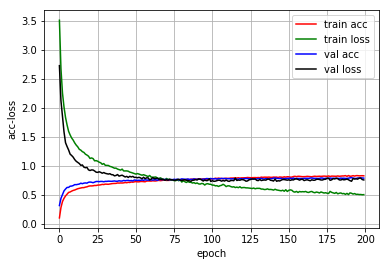

In [5]:
history.loss_plot('epoch')